# Censored Regression : Baysian Estimation

### 1. Please use the R function censReg() in library(censReg) to fit this model by MLE. Copy and paste the summary of the results here. 

In [656]:
library(censReg)

Loading required package: maxLik
Loading required package: miscTools

Please cite the 'maxLik' package as:
Henningsen, Arne and Toomet, Ott (2011). maxLik: A package for maximum likelihood estimation in R. Computational Statistics 26(3), 443-458. DOI 10.1007/s00180-010-0217-1.

If you have questions, suggestions, or comments regarding the 'maxLik' package, please use a forum or 'tracker' at maxLik's R-Forge site:
https://r-forge.r-project.org/projects/maxlik/

Please cite the 'censReg' package as:
Henningsen, Arne (2017). censReg: Censored Regression (Tobit) Models. R package version 0.5. http://CRAN.R-Project.org/package=censReg.

If you have questions, suggestions, or comments regarding the 'censReg' package, please use a forum or 'tracker' at the R-Forge site of the 'sampleSelection' project:
https://r-forge.r-project.org/projects/sampleselection/


In [657]:
sow.data = read.csv('CreditCard_SOW_data2.csv', header=T)

In [658]:
sow.creg = censReg(SOW ~ Promotion + Balance,left = 0, right = 1, data=sow.data)
summary(sow.creg)


Call:
censReg(formula = SOW ~ Promotion + Balance, left = 0, right = 1, 
    data = sow.data)

Observations:
         Total  Left-censored     Uncensored Right-censored 
          3600            831           2436            333 

Coefficients:
              Estimate Std. error t value Pr(> t)    
(Intercept)  6.016e-01  8.357e-03   71.98  <2e-16 ***
Promotion    5.072e-01  1.174e-02   43.21  <2e-16 ***
Balance     -5.107e-04  6.135e-06  -83.23  <2e-16 ***
logSigma    -1.604e+00  1.465e-02 -109.43  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Newton-Raphson maximisation, 9 iterations
Return code 1: gradient close to zero
Log-likelihood: -65.88155 on 4 Df


### 2. Please run the completed code. Use the plot() function to plot the posterior sampling chains and hist() to plot posterior histograms for β0, β1, β2 and $T$ . Copy and paste the results here.  Please also calculate the 95% posterior intervals for β0, β1, β2 and $T$  . Copy and paste the results here. 

In [581]:
library(truncnorm)
library(mnormt)

In [651]:
#Bayesian models fitting for truncated regression
#stage 1. read data into R and create columns for censored data
DataFile = "CreditCard_SOW_data2.csv"
sow.data = read.csv(DataFile, header=T)

In [652]:
sow.data$Cens0 = (sow.data$SOW==0)*1

In [653]:
sow.data$Cens1 = (sow.data$SOW==1)*1

In [654]:
#extract right and left censored data
sow.XRC = cbind(1, as.matrix(sow.data[sow.data$Cens0==1, 3:4]))
sow.XLC = cbind(1, as.matrix(sow.data[sow.data$Cens1==1, 3:4]))

In [632]:
sow.X   = cbind(1, as.matrix(sow.data[, 3:4]))

In [633]:
sow.X2  = t(sow.X)%*%sow.X
sow.X2.inv = solve(sow.X2)

In [634]:
nRC = dim(sow.XRC)[1]
nLC = dim(sow.XLC)[1]
nObs = dim(sow.data)[1]

In [635]:
#stage 2. Initial Setup for the algorithm
NIT       = 10000                        #num of interations
nBurn     = 2000                         #num of burn-ins  
NIT.eff   = NIT - nBurn                  #effective sample size
thin.step = 10                           #thinning  
NIT.thin  = floor(NIT.eff/thin.step)     #effective sample size after thinning

In [636]:
#stage 3. Record Posterior samples
beta.dim = 3
beta.pos = matrix(0, NIT.thin, beta.dim)


In [638]:
tau.pos  = rep(0, NIT.thin)

In [639]:
#stage 4. priors
#for Beta: mNormal(mu.beta, sigma.beta)

mu.beta     = rep(0,beta.dim)
sigma.beta  = 1E6  * diag(beta.dim)
iSigma.beta = 1E-6 * diag(beta.dim)  #inverse prior covariance matrix

In [640]:
#prior for precision: Gamma(a.tau, b.tau)
a.tau = 1/2
b.tau = 1/2

In [641]:
#stage 5. Gibbs sampler.

#initialize the loop
curBeta = c(0.5, 0, 0) 
curTau  = 4
g       = 1

In [642]:
#main loop
for (m in 1:NIT){
	#step 1. sample latent SOW 
	
    #step 1.a. sample SOW right-censored at 0
	#Please fill in the blank below the code for sampling the latent SOW when the observed SOW=0
	#Please name your sampled latent SOW curYRC
  
	#step 1.b sample SOW left-censored at 1
	#Please fill in the blank below the code for sampling the latent SOW when the observed SOW=1
	#Please name your sampled latent SOW curYLC

    mu_sow = sow.X %*% curBeta
    
    curYRC = rtruncnorm(nRC, mean = mu_sow[sow.data$Cens0==1], sd = sqrt(1/curTau), a = -Inf, b = 0)
    curYLC = rtruncnorm(nLC, mean = mu_sow[sow.data$Cens1==1], sd = sqrt(1/curTau), a = 1, b = Inf) 
  
	#step 2 sample beta
	#step 2.a impute the latent variables
	sow.Y = sow.data$SOW
	sow.Y[sow.data$Cens0==1] = curYRC
	sow.Y[sow.data$Cens1==1] = curYLC
    
    
	#step 2.b sample beta
	sigma.hat  = solve(curTau*sow.X2 + iSigma.beta)
	betaPos.mn = sigma.hat%*%(curTau*t(sow.X)%*%sow.Y +  iSigma.beta%*%mu.beta)
	curBeta    = as.vector(rmnorm(1, mean=betaPos.mn, varcov=sigma.hat)) 
	
	#step 3 sample tau (precision = 1/sigma^2)
	sowE.hat   = sow.Y-sow.X%*%curBeta
	curTau     = rgamma(1, 0.5*nObs+a.tau, 0.5*t(sowE.hat)%*%sowE.hat+b.tau)
	

	#save thinned samples after burn-ins
	if ((m > nBurn) & (m%%thin.step == 0)) {
		beta.pos[g,] = curBeta
		tau.pos[g] = curTau
		g = g+1
	}
}


In [643]:
colnames(beta.pos) = c('beta0', 'beta1', 'beta2')

In [644]:
# --------------------------------
# Get posterior mean of beta, tau
# --------------------------------
# (Intercept)     x1      x2 

(post_beta = colMeans(beta.pos))

beta0        beta1        beta2 
 0.602001463  0.507458988 -0.000511318

In [646]:
(post_tau  = mean(tau.pos))

[1] 24.45674

Warning message in cumsum(beta.pos[, 1])/(1:NIT):
"longer object length is not a multiple of shorter object length"Warning message in cumsum(beta.pos[, 2])/(1:NIT):
"longer object length is not a multiple of shorter object length"Warning message in cumsum(beta.pos[, 3])/(1:NIT):
"longer object length is not a multiple of shorter object length"

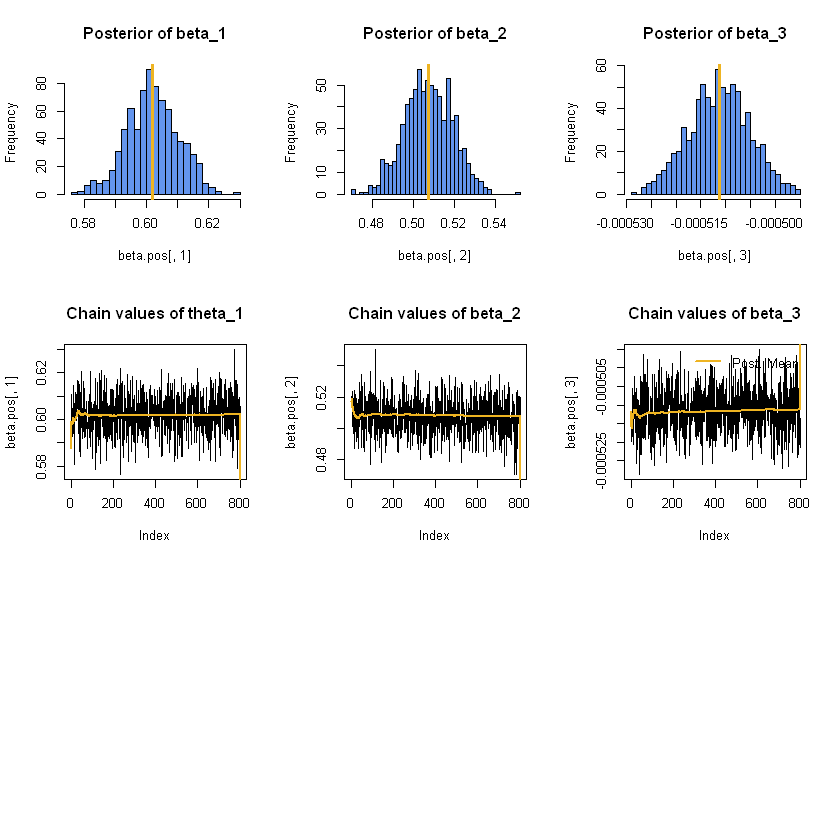

In [647]:
par(mfrow = c(3,3))
hist(beta.pos[,1], breaks=30, main="Posterior of beta_1", col="cornflowerblue")
abline(v = post_beta[1], col="goldenrod2", lwd=3)
hist(beta.pos[,2], breaks=30, main="Posterior of beta_2", col="cornflowerblue")
abline(v = post_beta[2], col="goldenrod2", lwd=3)
hist(beta.pos[,3], breaks=30, main="Posterior of beta_3", col="cornflowerblue")
abline(v = post_beta[3], col="goldenrod2", lwd=3)

plot(beta.pos[, 1], type = "l", main = "Chain values of theta_1")
lines(cumsum(beta.pos[, 1])/(1:NIT), col="goldenrod2", lwd=2)
plot(beta.pos[, 2], type = "l", main = "Chain values of beta_2")
lines(cumsum(beta.pos[, 2])/(1:NIT), col="goldenrod2", lwd=2)
plot(beta.pos[, 3], type = "l", main = "Chain values of beta_3")
lines(cumsum(beta.pos[, 3])/(1:NIT), col="goldenrod2", lwd=2)

legend("topright", "Post. Mean", lty=1, lwd=2, col="goldenrod2", bty='n', cex=.95)

In [648]:
#install.packages('HDInterval')
library(HDInterval)

Installing package into 'C:/Users/cl44343/Documents/R/win-library/3.4'
(as 'lib' is unspecified)
Warning message:
"package 'HDInterval' is in use and will not be installed"

In [649]:
hdi(beta.pos, credMass = 0.95)

,beta0,beta1,beta2
lower,0.5875770,0.4837415,-0.0005235368
upper,0.6199942,0.5282195,-0.0004998265


In [650]:
hdi(tau.pos, credMass = 0.95)

lower    upper 
23.06265 25.88351 
attr(,"credMass")
[1] 0.95